In [1]:
import sys
sys.path.append("/s/ls4/users/grartem/RL_robots/continuous-grid-arctic/src")
sys.path.append("/s/ls4/users/grartem/RL_robots/RL_robotSim/")
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"

In [2]:
os.chdir("/s/ls4/users/grartem/RL_robots/RL_robotSim/")

In [3]:
import time
import gym
import pyhocon
import numpy as np
import pandas as pd
import ray
from ray.rllib.agents.ppo.ppo import PPOTrainer
from ray.rllib.agents.ddpg.td3 import TD3Trainer
import pygame
import matplotlib.pyplot as plt
import MyTfModel
import MyNewModels
%matplotlib inline

import MyMisc

pygame 2.1.2 (SDL 2.0.16, Python 3.8.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Prepare env and model

In [16]:
configs = pyhocon.ConfigFactory.parse_file("/s/ls4/users/grartem/RL_robots/RL_robotSim/Configs/FollowerContinuous/PPO_dyn_obst_2.conf")
#CONFIG = configs["ppo_e28_b1_f14v2_prev5_m_trans_v4v2"].as_plain_ordered_dict()
CONFIG = configs["ppo_e29_f16_b2mv4"].as_plain_ordered_dict()
CONFIG["config"]["num_workers"]=1

In [17]:
CONFIG["config"]["env_config"]

OrderedDict([('name', 'Test-Cont-Env-Auto-v0'),
             ('base_env_config',
              OrderedDict([('add_obstacles', True),
                           ('max_distance', 4),
                           ('warm_start', 0),
                           ('max_steps', 10000),
                           ('framerate', 5000),
                           ('obstacle_number', 35),
                           ('constant_follower_speed', False),
                           ('corridor_length', 10),
                           ('corridor_width', 1.5),
                           ('move_bear_v4', True),
                           ('follower_speed_koeff', 0.6),
                           ('negative_speed', True),
                           ('bear_speed_coeff', 1.2),
                           ('early_stopping',
                            OrderedDict([('max_distance_coef', 3.5),
                                         ('low_reward', -300)])),
                           ('random_frames_per_step', [2, 20

In [18]:
EXPERIMENT_DIR = "/s/ls4/users/grartem/RL_robots/RL_robotSim/results/FollowerContinuous_test_sensors/env29/PPO/default_model/feats_v14VPC/bear2/ppo_e29_b2_f14VPC_mv4_backup/PPO_continuous-grid_399ae_00000_0_2023-07-21_14-24-58/"
checkpoint_path = EXPERIMENT_DIR + "/checkpoint_000300/checkpoint-300"


In [19]:
trainer = ray.rllib.agents.registry.get_trainer_class(CONFIG["run"])(CONFIG["config"])
#trainer = ray.rllib.agents.registry.get_trainer_class("PPO")(CONFIG)
#trainer.restore(checkpoint_path)

env = MyMisc.continuous_env_maker(config=CONFIG["config"]["env_config"])
#env = MyMisc.continuous_env_maker(config=CONFIG["env_config"])

(RolloutWorker pid=19881) pygame 2.1.2 (SDL 2.0.16, Python 3.8.0)
(RolloutWorker pid=19881) Hello from the pygame community. https://www.pygame.org/contribute.html


(RolloutWorker pid=19881) /s/ls4/users/grartem/RL_robots/continuous_grid_arctic/src/continuous_grid_arctic/follow_the_leader_continuous_env.py:328: UserWarning: Одновременно заданы и random_frames_per_step и frames_per_step, будет использоваться random_frames_per_step
(RolloutWorker pid=19881)   warn(
(RolloutWorker pid=19881) /s/ls4/users/grartem/anaconda3/envs/rl_robots/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=19881)   logger.warn(


(RolloutWorker pid=19881) ===Запуск симуляции номер 0===
(RolloutWorker pid=19881) {'LeaderPositionsTracker_v2': <src.continuous_grid_arctic.utils.sensors.LeaderPositionsTracker_v2 object at 0x2b3a4c707a90>, 'LeaderCorridor_Prev_lasers_v2_corridor': <src.continuous_grid_arctic.utils.sensors.LeaderCorridor_lasers_compas object at 0x2b3a4c7079d0>, 'LeaderCorridor_Prev_lasers_v2_obst': <src.continuous_grid_arctic.utils.sensors.LeaderCorridor_Prev_lasers_v2 object at 0x2b3a4c707700>}


(RolloutWorker pid=19881) Failed to create secure directory (/run/user/1556/pulse): No such file or directory
(RolloutWorker pid=19881) ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
(RolloutWorker pid=19881) ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
(RolloutWorker pid=19881) ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
(RolloutWorker pid=19881) ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
(RolloutWorker pid=19881) ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
(RolloutWorker pid=19881) ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
(RolloutWorker pid=19881) ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
(RolloutWorker pid=19881) ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default


(RolloutWorker pid=19881) Model: "model"
(RolloutWorker pid=19881) __________________________________________________________________________________________________
(RolloutWorker pid=19881) Layer (type)                    Output Shape         Param #     Connected to                     
(RolloutWorker pid=19881) ==================================================================================================
(RolloutWorker pid=19881) observations (InputLayer)       [(None, 5, 84)]      0                                            
(RolloutWorker pid=19881) __________________________________________________________________________________________________
(RolloutWorker pid=19881) flatten (Flatten)               (None, 420)          0           observations[0][0]               
(RolloutWorker pid=19881) __________________________________________________________________________________________________
(RolloutWorker pid=19881) my_layer2 (Dense)               (None, 256)          10777

(RolloutWorker pid=19881) 2023-08-08 20:23:17,888	WARNING deprecation.py:45 -- DeprecationWarning: `SampleBatch['is_training']` has been deprecated. Use `SampleBatch.is_training` instead. This will raise an error in the future!


(RolloutWorker pid=19881) sample_collector_class <class 'ray.rllib.evaluation.collectors.simple_list_collector.SimpleListCollector'>
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
observations (InputLayer)       [(None, 5, 84)]      0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 420)          0           observations[0][0]               
__________________________________________________________________________________________________
my_layer2 (Dense)               (None, 256)          107776      flatten[0][0]                    
__________________________________________________________________________________________________
my_layer1 (Dense)               (None, 256)          65792  

2023-08-08 20:23:21,242	INFO trainable.py:124 -- Trainable.setup took 13.636 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2023-08-08 20:23:21,247	WARNING util.py:57 -- Install gputil for GPU system monitoring.


In [20]:
policy = trainer.get_policy()
print(type(policy))
print(type(policy.model))

<class 'ray.rllib.policy.tf_policy_template.PPOTFPolicy'>
<class 'MyNewModels.DefaultModelPrev'>


In [21]:
policy.model.base_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
observations (InputLayer)       [(None, 5, 84)]      0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 420)          0           observations[0][0]               
__________________________________________________________________________________________________
my_layer2 (Dense)               (None, 256)          107776      flatten[0][0]                    
__________________________________________________________________________________________________
my_layer1 (Dense)               (None, 256)          65792       my_layer2[0][0]                  
______________________________________________________________________________________________

# Test episode

In [22]:
# Start env episode
seed_i = 194
env.seed(seed_i)
obs = env.reset()
done = False
total_reward = 0.0

===Запуск симуляции номер 0===
{'LeaderPositionsTracker_v2': <src.continuous_grid_arctic.utils.sensors.LeaderPositionsTracker_v2 object at 0x2b64df7f4e50>, 'LeaderCorridor_Prev_lasers_v2_corridor': <src.continuous_grid_arctic.utils.sensors.LeaderCorridor_lasers_compas object at 0x2b70aad4e9a0>, 'LeaderCorridor_Prev_lasers_v2_obst': <src.continuous_grid_arctic.utils.sensors.LeaderCorridor_Prev_lasers_v2 object at 0x2b673b7ec730>}


In [23]:
# run N steps
NNobs_history, raw_obs_history, reward_history, info_history, actions_hist = [], [], [], [], []
obs_history = []
start_time = time.time()
for i in range(50):
    # Compute a single action, given the current observation
    # from the environment.
    NNobs_history.append(obs)
    raw_obs = env.env.env._get_obs()
    raw_obs_history.append({
        #'LeaderTrackDetector_radar': raw_obs['LeaderTrackDetector_radar'],
        #'LeaderCorridor_lasers': raw_obs['LeaderCorridor_lasers']
        #'LeaderCorridor_lasers': raw_obs['LeaderCorridor_lasers']
        "numerical_features": raw_obs["numerical_features"]
    })
    
    pred_result = trainer.compute_single_action(obs, explore=False, full_fetch=True)
    action = pred_result[0]
    # Apply the computed action in the environment.
    #obs, reward, done, info = env.step(action)
    obs, reward, done, info = env.step([0.9, 0.0])
    obs_history.append(obs)
    
    actions_hist.append(action)
    reward_history.append(reward)
    info_history.append(info)
    # Sum up rewards for reporting purposes.
    total_reward += reward
    if done:
        break
elapsed_time = time.time() - start_time
elapsed_time = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
print(elapsed_time)
#1:19

00:00:02


In [13]:
import joblib
raw_obs_history_new = joblib.dump(raw_obs_history, "raw_obs_history.joblib")
NNobs_history_new = joblib.dump(NNobs_history, "NNobs_history.joblib")

In [23]:
!pwd

/s/ls4/users/grartem/RL_robots/RL_robotSim


In [17]:

raw_obs_history_old = joblib.load("raw_obs_history.old")
NNobs_history_old = joblib.load("NNobs_history.old")

In [13]:
len(NNobs_history)

1

In [24]:
NNobs_history[-1]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.69907314, 0.8774519 ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.7071096 , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.70710945, 0.51764005, 0.5176401 , 0.        , 0.        ,
        0.        , 0.7071039 , 0.51763606, 0.5176361 , 0.70710415,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 1.        , 1.        , 0.53787935, 1.        ,
        1.        , 1.        , 1.        , 1.        , 0.5873738 ,
        1.        , 1.        , 1.        , 1.  

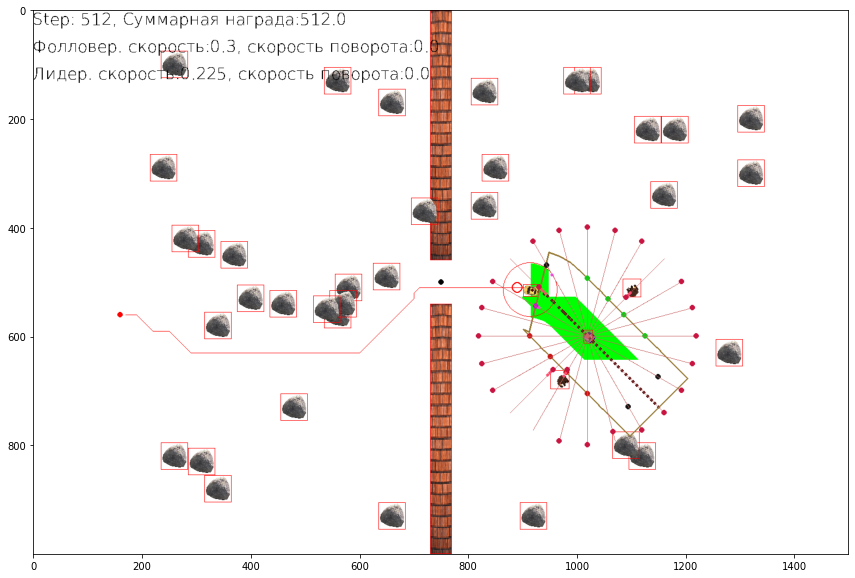

In [25]:
env.render()
plt.figure(figsize=(15,10))
plt.imshow(pygame.surfarray.array3d(env.gameDisplay).transpose((1,0,2)))

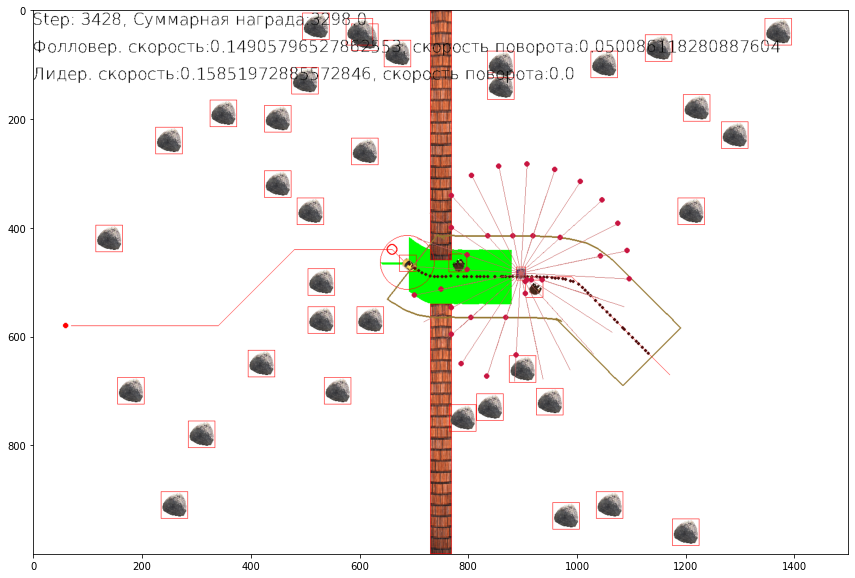

In [32]:
env.render()
plt.figure(figsize=(15,10))
plt.imshow(pygame.surfarray.array3d(env.gameDisplay).transpose((1,0,2)))

In [169]:
env.follower.rectangle.center, env.follower.position, env.env.env.game_dynamic_list[0].rectangle.center, env.env.env.game_dynamic_list[0].position

((1345, 743), array([1012.,  680.]), (1040, 530), (1340.0, 530.0))

In [ ]:
env.follower.rectangle.move()

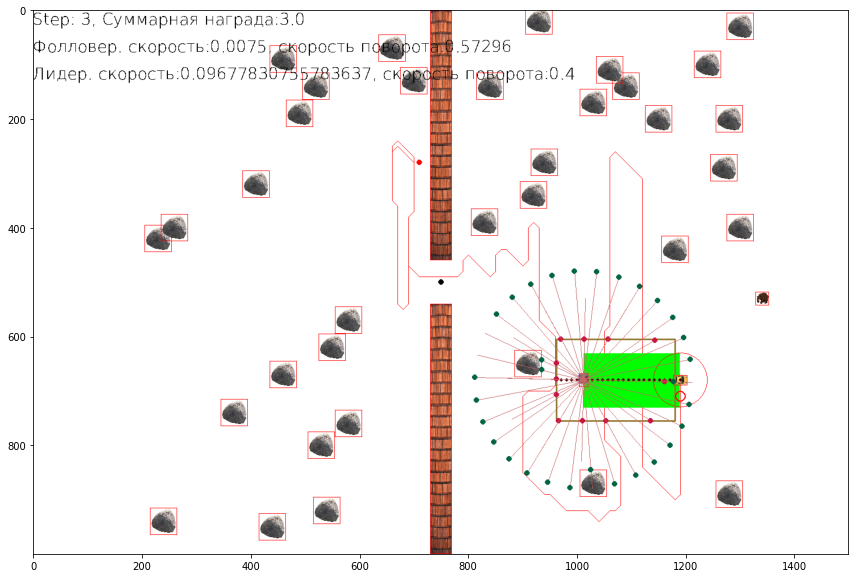

In [14]:
env.render()
plt.figure(figsize=(15,10))
plt.imshow(pygame.surfarray.array3d(env.gameDisplay).transpose((1,0,2)))